<a href="https://colab.research.google.com/github/ChoiDM/LiTS/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
import keras.backend as K
import tensorflow as tf

In [5]:
!pip install nibabel

    100% |████████████████████████████████| 4.2MB 8.3MB/s 
  Running setup.py bdist_wheel for nibabel ... - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/6d/50/60/a2fcafe72ababac5240b3df2ee903197bec24b74d75840153f
Successfully built nibabel


In [0]:
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

In [7]:
from google.colab import drive
drive.mount("/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [8]:
cd /gdrive/My \Drive/Segmentation/LITS

/gdrive/My Drive/Segmentation/LITS


In [9]:
img_path = glob("Training Batch 1/volume-*.nii")
mask_path = glob("Training Batch 1/segmentation-*.nii")

print("Number of images :", len(img_path))

Number of images : 28


## Utils

In [0]:
patch_ratio = []

for i in range(16 + 1):
  patch_ratio.append(32 * i)

In [11]:
patch_ratio

[0,
 32,
 64,
 96,
 128,
 160,
 192,
 224,
 256,
 288,
 320,
 352,
 384,
 416,
 448,
 480,
 512]

In [0]:
def patch_sampling(img, mask, patch_ratio, pos_neg_ratio, threshold):
  
  temp_mask = mask
  
  temp_mask[temp_mask == 1] = 0
  temp_mask[temp_mask == 2] = 1
  
  positive_patch = []
  positive_mask = []
  
  negative_patch = []
  negative_mask = []
  
  negative_set = []
  
  
  for i in range(temp_mask.shape[2]):
    for x_bin in range(2, len(patch_ratio)):
        for y_bin in range(2, len(patch_ratio)):
          img_patch = img[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          mask_patch = temp_mask[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin], i]
          _, count = np.unique(mask_patch, return_counts = True)
          
          if len(count) == 2:
            mask_percentage = count[1] / sum(count) * 100
          
            if threshold < mask_percentage :
              positive_patch.append(img_patch)
              positive_mask.append(mask_patch)
          
          
          elif len(count) ==1:
            
            temp_list = []
            temp_list.append(img_patch)
            temp_list.append(mask_patch)
            
            negative_set.append(temp_list)
  
  shuffle(negative_set)
  
  negative_set_to_use = negative_set[:len(positive_patch) * pos_neg_ratio]
  for negative_set in negative_set_to_use:
    negative_patch.append(negative_set[0])
    negative_mask.append(negative_set[1])
  
  negative_set_to_use = []
  
  return positive_patch, positive_mask, negative_patch, negative_mask

In [0]:
def slice_to_patch(slice, patch_ratio):
  
  slice[slice == 1] = 0
  slice[slice == 2] = 1
  
  patch_list = []
  
  for x_bin in range(2, len(patch_ratio)):
    for y_bin in range(2, len(patch_ratio)):
      patch = slice[patch_ratio[x_bin-2] : patch_ratio[x_bin], patch_ratio[y_bin - 2] : patch_ratio[y_bin]]
      patch = patch.reshape(patch.shape + (1,))
      patch_list.append(patch)
  
  return np.array(patch_list)

In [0]:
def patch_to_slice(patch, patch_ratio, input_shape):
  
  slice = np.zeros((512, 512, 1))
  row_idx = 0
  col_idx = 0
  
  for i in range(len(patch)):
    
    slice[patch_ratio[row_idx]:patch_ratio[row_idx + 2], patch_ratio[col_idx]:patch_ratio[col_idx + 2]][patch[i] == 1] = 1
    
    col_idx += 1
    
    if i != 0 and (i+1) % 15 == 0:
      row_idx += 1
      col_idx = 0
  
  return slice

In [0]:
def weighted_binary_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 10e-8, 1.-10e-8)
    loss = - (y_true * K.log(y_pred) * 0.90 + (1 - y_true) * K.log(1 - y_pred) * 0.10)
    
    return K.mean(loss)

## Model

In [0]:
input_shape = [64, 64, 1]

In [0]:
def u_net(input_shape):
  
  # Encoder
  input = Input(shape = input_shape, name = "input")
  conv1_1 = Conv2D(32, (3, 3), padding = "same", activation='relu', name = "conv1_1")(input)
  conv1_2 = Conv2D(32, (3, 3), padding = "same", activation='relu', name = "conv1_2")(conv1_1)
  pool1 = MaxPooling2D(name = "pool1")(conv1_2)
  
  conv2_1 = Conv2D(64, (3, 3), padding = "same", activation='relu', name = "conv2_1")(pool1)
  conv2_2 = Conv2D(64, (3, 3), padding = "same", activation='relu', name = "conv2_2")(conv2_1)
  pool2 = MaxPooling2D(name = "pool2")(conv2_2)
  
  conv3_1 = Conv2D(128, (3, 3), padding = "same", activation='relu', name = "conv3_1")(pool2)
  conv3_2 = Conv2D(128, (3, 3), padding = "same", activation='relu', name = "conv3_2")(conv3_1)
  pool3 = MaxPooling2D(name = "pool3")(conv3_2)
  
  conv4_1 = Conv2D(256, (3, 3), padding = "same", activation='relu', name = "conv4_1")(pool3)
  conv4_2 = Conv2D(256, (3, 3), padding = "same", activation='relu', name = "conv4_2")(conv4_1)
  pool4 = MaxPooling2D(name = "pool4")(conv4_2)
  
  conv5_1 = Conv2D(512, (3, 3), padding = "same", activation='relu', name = "conv5_1")(pool4)
  conv5_2 = Conv2D(512, (3, 3), padding = "same", activation='relu', name = "conv5_2")(conv5_1)
  
  
  # Decoder
  upconv6 = UpSampling2D()(conv5_2) 
  upconv6 = Conv2D(256, (2, 2), padding = "same", name = "upconv6")(upconv6)
  concat6 = concatenate([conv4_2, upconv6], name = "concat6")
  conv6_1 = Conv2D(256, (3, 3), padding = "same", name = "conv6_1")(concat6)
  conv6_2 = Conv2D(256, (3, 3), padding = "same", name = "conv6_2")(conv6_1)
  
  upconv7 = UpSampling2D()(conv6_2) 
  upconv7 = Conv2D(128, (2, 2), padding = "same", name = "upconv7")(upconv7)
  concat7 = concatenate([conv3_2, upconv7], name = "concat7")
  conv7_1 = Conv2D(128, (3, 3), padding = "same", name = "conv7_1")(concat7)
  conv7_2 = Conv2D(128, (3, 3), padding = "same", name = "conv7_2")(conv7_1)
  
  upconv8 = UpSampling2D()(conv7_2) 
  upconv8 = Conv2D(64, (2, 2), padding = "same", name = "upconv8")(upconv8)
  concat8 = concatenate([conv2_2, upconv8], name = "concat8")
  conv8_1 = Conv2D(64, (3, 3), padding = "same", name = "conv8_1")(concat8)
  conv8_2 = Conv2D(64, (3, 3), padding = "same", name = "conv8_2")(conv8_1)
  
  upconv9 = UpSampling2D()(conv8_2) 
  upconv9 = Conv2D(32, (2, 2), padding = "same", name = "upconv9")(upconv9)
  concat9 = concatenate([conv1_2, upconv9], name = "concat9")
  conv9_1 = Conv2D(32, (3, 3), padding = "same", name = "conv9_1")(concat9)
  conv9_2 = Conv2D(32, (3, 3), padding = "same", name = "conv9_2")(conv9_1)
  dropout = Dropout(0.5)(conv9_2)
  
  conv10 = Conv2D(1, (1, 1), padding = "same", activation = 'sigmoid', name = "conv10")(dropout)

 
  model = Model(input, conv10)
  
  return model

In [0]:
model = u_net(input_shape)

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 64, 64, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 64, 64, 32)   9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 32, 32, 32)   0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

## Training

In [0]:
adam = Adam(lr = 0.0001, decay = 0.01)

In [0]:
model.compile(optimizer = adam, loss = weighted_binary_crossentropy, metrics = ['accuracy'])

In [0]:
total_data = 0

for i in range(len(img_path)):
  
  img_3D = nib.load(img_path[i]).get_data()
  mask_3D = nib.load(mask_path[i]).get_data()
  
  pos_patch, pos_mask, neg_patch, neg_mask = patch_sampling(img_3D, mask_3D, patch_ratio, 3, 3.0)
  total_patch = pos_patch + neg_patch
  total_mask = pos_mask + neg_mask
  
  X_array = np.array(total_patch).reshape((len(total_patch), 64, 64, 1))
  y_array = np.array(total_mask).reshape((len(total_mask), 64, 64, 1))
  total_data += len(total_patch)
  
  print("======= Step [{0} / {1}] : # of patches = {2} | # of total training images = {3} =======".format(i+1, len(img_path), len(total_patch), total_data))
  
  if y_array.shape[0] != 0:
    model.fit(X_array, y_array, batch_size = 8, epochs = 150)

## Save
Reference : [Link](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

In [0]:
model_json = model.to_json()
with open("model_expand.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_expand.h5")

## Load

In [17]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [45]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 64, 64, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 32, 32, 32)   0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 32, 32, 64)   18496       pool1[0][0]                      
__________________________________________________________________________________________________
pool2 (Max

## Example

In [0]:
img_ex = nib.load(img_path[25]).get_data()
mask_ex = nib.load(mask_path[25]).get_data()

In [0]:
slice_num = 371

In [0]:
patch_ex = slice_to_patch(img_ex[:, :, slice_num], patch_ratio)
mask_patch = slice_to_patch(mask_ex[:, :, slice_num], patch_ratio)

In [0]:
prediction = loaded_model.predict(patch_ex)

In [0]:
prediction_mask = patch_to_slice(prediction, patch_ratio, input_shape)

Text(0.5,1,'Mask (Prediction)')

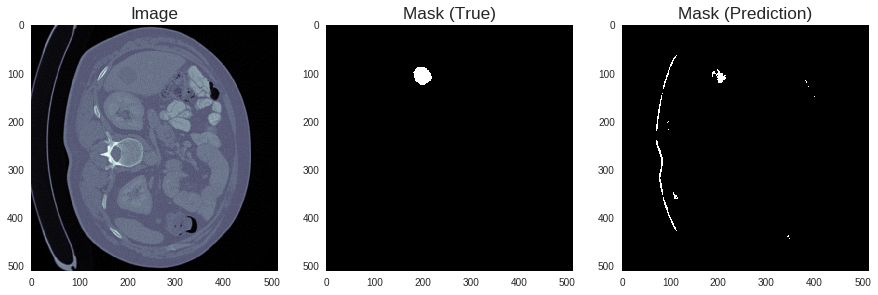

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))

ax1.imshow(img_ex[:, :, slice_num].reshape((512, 512)), cmap = 'bone')
ax1.grid(False)
ax1.set_title("Image", fontsize = "x-large")

ax2.imshow(mask_ex[:, :, slice_num].reshape((512, 512)), cmap = 'bone')
ax2.grid(False)
ax2.set_title("Mask (True)", fontsize = "x-large")

ax3.imshow(prediction_mask.reshape((512, 512)), cmap = 'bone')
ax3.grid(False)
ax3.set_title("Mask (Prediction)", fontsize = "x-large")